<a href="https://colab.research.google.com/github/shawnmalik1/lab_scraping/blob/main/lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [5]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
# df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(73, 6)


,title,price,year,link,brand,age
0,acura mdx 2007 sport (technology package) (pri...,3500,2007.0,https://charlottesville.craigslist.org/cto/d/l...,acura,18.0
1,2014 jeep wrangler sport,12500,2014.0,https://charlottesville.craigslist.org/cto/d/k...,jeep,11.0
2,"2017 ford fiesta titanium, 43,000 miles.",10495,2017.0,https://charlottesville.craigslist.org/cto/d/o...,ford,8.0
3,work van,2600,NaN,https://charlottesville.craigslist.org/cto/d/p...,missing,NaN
4,2002 ford ranger (look),4800,2002.0,https://charlottesville.craigslist.org/cto/d/c...,ford,23.0


With the data in and wrangled, we can now do some analysis:

count       73.000000
mean     11337.643836
std      13729.607356
min       1000.000000
25%       3500.000000
50%       5900.000000
75%      14000.000000
max      79999.000000
Name: price, dtype: float64


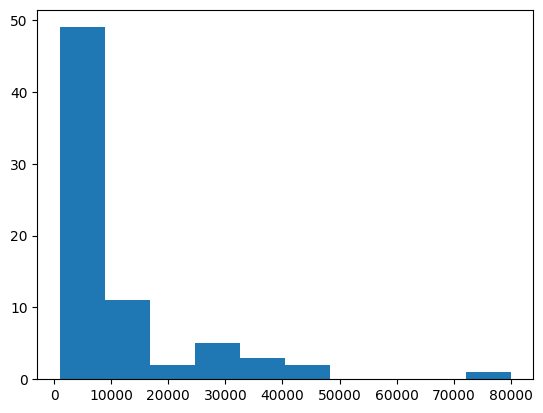

count    64.00000
mean     16.40625
std      10.69597
min       2.00000
25%      11.00000
50%      14.50000
75%      19.00000
max      62.00000
Name: age, dtype: float64


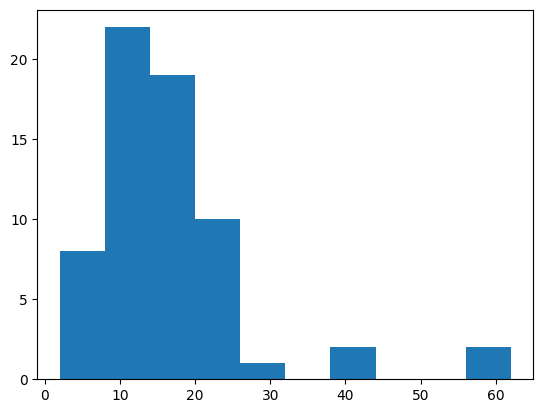

In [6]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [7]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
acura        1.0   3500.000000           NaN   3500.0   3500.00   3500.0   
audi         1.0  46500.000000           NaN  46500.0  46500.00  46500.0   
bmw          3.0  13743.333333   3029.460898  10500.0  12365.00  14230.0   
chevrolet    1.0   3500.000000           NaN   3500.0   3500.00   3500.0   
chevy        4.0  12612.250000  10886.859063   2999.0   3712.25  11225.0   
dodge        2.0  27000.000000  18384.776311  14000.0  20500.00  27000.0   
ford         6.0  12082.500000  12527.603023   1000.0   2100.00   7647.5   
honda        6.0   4391.666667   2017.031647   1000.0   3750.00   4700.0   
jeep         5.0   8990.000000   5182.952826   3250.0   5700.00   7500.0   
kia          1.0   1250.000000           NaN   1250.0   1250.00   1250.0   
lexus        2.0  16750.000000  16617.009358   5000.0  10875.00  16750.0   
mazda        1.0   1000.000000           NaN   1000.0   1000.00   1000.0   
missing     24.0  12774.541667  18580.542822   1000.0   2900.00   5250.0   
mitsubishi   1.0   5800.000000           NaN   5800.0   5800.00   5800.0   
porsche      1.0  23900.000000           NaN  23900.0  23900.00  23900.0   
subaru       3.0   5583.333333   3125.833222   2000.0   4500.00   7000.0   
toyota       9.0   9344.444444  10079.200255   1500.0   5900.00   7400.0   
volkswagen   1.0   7500.000000           NaN   7500.0   7500.00   7500.0   
volvo        1.0   4285.000000           NaN   4285.0   4285.00   4285.0   

                               
                 75%      max  
brand                          
acura        3500.00   3500.0  
audi        46500.00  46500.0  
bmw         15365.00  16500.0  
chevrolet    3500.00   3500.0  
chevy       20125.00  25000.0  
dodge       33500.00  40000.0  
ford        21373.75  30000.0  
honda        5350.00   6950.0  
jeep        12500.00  16000.0  
kia          1250.00   1250.0  
lexus       22625.00  28500.0  
mazda        1000.00   1000.0  
missing     11250.00  79999.0  
mitsubishi   5800.00   5800.0  
porsche     23900.00  23900.0  
subaru       7375.00   7750.0  
toyota       8000.00  35500.0  
volkswagen   7500.00   7500.0  
volvo        4285.00   4285.0

In [8]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        1.0  18.000000        NaN  18.0  18.00  18.0  18.00  18.0
audi         1.0   2.000000        NaN   2.0   2.00   2.0   2.00   2.0
bmw          3.0  13.000000   6.928203   9.0   9.00   9.0  15.00  21.0
chevrolet    0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
chevy        4.0  22.000000  12.569805   9.0  15.75  20.0  26.25  39.0
dodge        2.0  10.000000   1.414214   9.0   9.50  10.0  10.50  11.0
ford         6.0  13.000000   8.763561   4.0   5.00  12.5  20.75  23.0
honda        6.0  17.000000   4.242641  12.0  13.50  17.0  20.50  22.0
jeep         5.0  22.600000  11.436783  11.0  17.00  19.0  25.00  41.0
kia          0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
lexus        2.0  11.000000   8.485281   5.0   8.00  11.0  14.00  17.0
mazda        1.0  14.000000        NaN  14.0  14.00  14.0  14.00  14.0
missing     18.0  17.611111  15.770930   5.0  10.25  13.0  17.00  62.0
mitsubishi   1.0  23.000000        NaN  23.0  23.00  23.0  23.00  23.0
porsche      1.0  12.000000        NaN  12.0  12.00  12.0  12.00  12.0
subaru       3.0  16.666667   8.962886  11.0  11.50  12.0  19.50  27.0
toyota       8.0  14.500000   6.233550   3.0  12.50  15.0  16.50  25.0
volkswagen   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
volvo        1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0

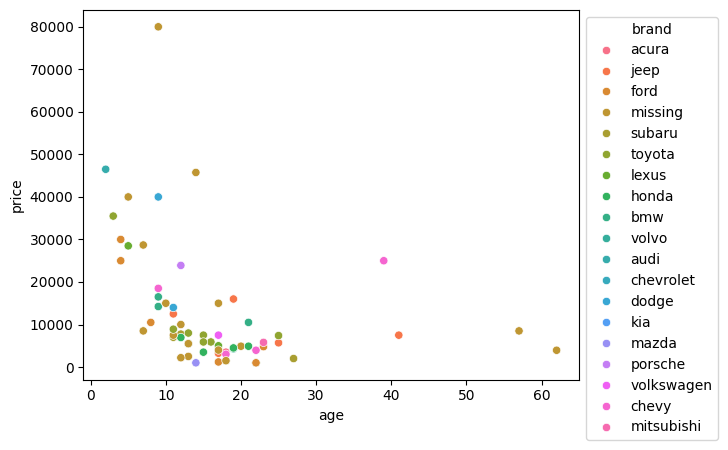

In [9]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   1.064274 -0.348390
log_age    -0.348390  0.381663
           log_price   log_age
log_price   1.000000 -0.553816
log_age    -0.553816  1.000000


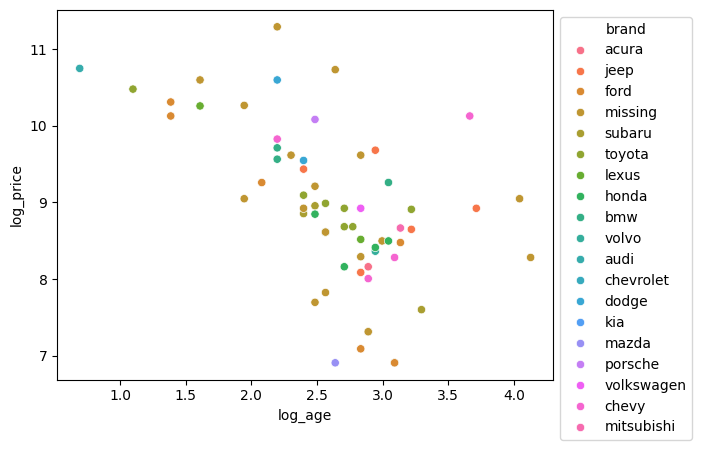

In [10]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

list: https://charlottesville.craigslist.org/search/apa#search=2~gallery~0 (housing/apartment)

fields like to gather: title, price, # of bedroom, # of bathrooms, location, link

EDAs: price x location, price x (# of bedrooms/bathrooms)

In [11]:
url = 'https://charlottesville.craigslist.org/search/apa?min_bathrooms=1&min_bedrooms=1#search=2~gallery~6' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [18]:
bathroom = ['bathroom', 'bath', 'bth']
bedroom = ['bedroom', 'bed', 'bd']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    location_raw = listings[k].find('div',class_='location')
    if location_raw is None:
      location = "missing"
    else:
      location = location_raw.get_text().lower()

    # Get number of bathrooms from the title string:
    words = title.split()
    hits1 = [word for word in words if word in bathroom] # Find bathroom in the title
    regex_search = re.search(r'[0-9].'+hits1[0], title)
    if regex_search is None: # If no hits, record bath as missing value
        bath = np.nan
    else: # If hits, record bath as first match
        bath = regex_search.group(0)
    # Get number of beds from the title string:
    words = title.split()
    hits2 = [word for word in words if word in bedroom] # Find bedroom in the title
    regex_search = re.search(r'[0-9]'+hits2[0], title)
    if regex_search is None: # If no hits, record bed as missing value
        bed = np.nan
    else: # If hits, record bed as first match
        bed = regex_search.group(0)

    data.append({'title':title,'price':price,'location':location,'link':link,'bathroom':bath, 'bedroom':bed})

IndexError: list index out of range

In [21]:
data
words

['modern',
 '4br',
 'townhome',
 'in',
 'old',
 'trail',
 'community,',
 'easy',
 'commute',
 'to',
 'uva',
 '-',
 'furn']

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
#df.to_csv('./src/craigslist_cville_cars.csv')
df.to_csv('./src/craigslist_cville_') # Save data in case of a disaster
df.head()

In [ ]:
print(df[''].describe())
df[''].hist(grid=False)
plt.show()

In [ ]:
#cross tables

# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

In [ ]:
# scatterplots and other visualizations
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))